In [1]:
%load_ext autoreload
%autoreload 2

# Test smina (and AmberTools)

(Not completed)

In [2]:
from rdkit import Chem
from cbiprep.pdbatoms import PDBAtoms
from cbiprep.ligand_expo import LigandExpo
import pandas as pd
import subprocess as sp
import os, re

RDKit WARNING: [02:12:01] Enabling RDKit 2019.09.3 jupyter extensions


In [3]:
pdb_code = '4jn2'

In [4]:
pdb_atoms = PDBAtoms(f'pdb/{pdb_code}.pdb.gz')
len(pdb_atoms)

8217

In [5]:
lig_expo = LigandExpo()

In [6]:
df = pd.read_pickle('index_2019.pkl.gz')

In [7]:
lig_name = df[df['pdb'] == pdb_code]['lig'].item()
lig_name

'4CC'

In [8]:
lig_atoms = pdb_atoms.get_ligand(lig_name)

In [9]:
protein_atoms = pdb_atoms.get_relevant_protein(lig_atoms, thres=4)
len(protein_atoms)

3336

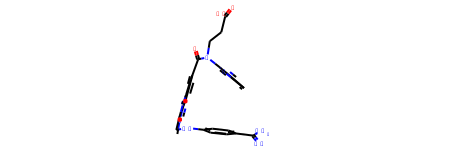

In [10]:
for lig_mol in Chem.SDMolSupplier(f'work/{pdb_code}/{pdb_code}_ligand_{lig_name}.sdf'):
    break
lig_mol

In [11]:
smi = Chem.MolToSmiles(lig_mol)
smi

'Cn1c(CNc2ccc(C(=N)N)cc2)nc2cc(C(=O)N(CCC(=O)O)c3ccccn3)ccc21'

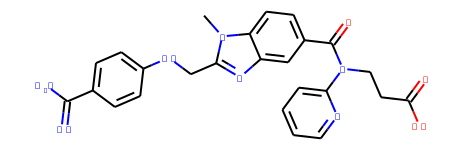

In [12]:
mol_2D = Chem.MolFromSmiles(Chem.MolToSmiles(lig_mol))
mol_2D

In [13]:
oname = f'work/{pdb_code}/{pdb_code}_relevant.pdb'
open(oname, 'wt').write(str(protein_atoms) + '\n')

270216

In [14]:
!ls -l work/4jn2

合計 1664
-rw-r--r-- 1 rhara users 661445  8月 10 02:06 4jn2_charged.mol2
-rw-r--r-- 1 rhara users   3021  8月  9 19:03 4jn2_ligand_4CC.sdf
-rw-r--r-- 1 rhara users  14816  8月 10 02:07 4jn2_ligand_4CC_docked.sdf
-rw-r--r-- 1 rhara users    991  8月 10 02:07 4jn2_ligand_4CC_smina.log
-rw-r--r-- 1 rhara users  15228  8月  9 19:03 4jn2_pocket.pdb
-rw-r--r-- 1 rhara users 645864  8月 10 02:06 4jn2_relevant.mol2
-rw-r--r-- 1 rhara users 270216  8月 10 02:12 4jn2_relevant.pdb
-rw-r--r-- 1 rhara users  66120  8月 10 02:06 4jn2_tleap.log
-rw-r--r-- 1 rhara users   5403  8月 10 02:06 4jn2_tleaprc


### tleap (protein structure prep)

In [15]:
tleaprc_template = os.path.abspath(os.path.dirname(Chem.__file__) + '/../../../../../cbiprep/data/tleaprc.template')
os.path.exists(tleaprc_template)

True

In [16]:
logFile = f'work/{pdb_code}/{pdb_code}_tleap.log'
test = f'work/{pdb_code}/{pdb_code}_relevant.pdb'
saveMol2 = f'work/{pdb_code}/{pdb_code}_relevant.mol2'
oname = f'work/{pdb_code}/{pdb_code}_tleaprc'
cont = open(tleaprc_template, 'rt').read()
cont = cont.replace('{{logFile}}', logFile).replace('{{test}}', test).replace('{{saveMol2}}', saveMol2)
open(oname, 'wt').write(cont)

5403

In [17]:
command = f'tleap -s -f {oname} > /dev/null 2>&1'
sp.call(command, shell=True)

0

### Docking by SMINA

In [18]:
receptor = f'work/{pdb_code}/{pdb_code}_charged.mol2'
command = f'obabel {saveMol2} -O {receptor} > /dev/null 2>&1'
sp.call(command, shell=True)

0

In [19]:
ligand = f'work/{pdb_code}/{pdb_code}_ligand_{lig_name}.sdf'

In [20]:
boxpars = sp.check_output(f'ligand_center {ligand}', shell=True).decode().strip()
boxpars

'--center_x -36.929 --center_y 56.106 --center_z 3.746 --size_x 17.329 --size_y 21.632 --size_z 19.077'

In [21]:
ncpu = 10
num_modes = 4
seed = 0
oname = f'work/{pdb_code}/{pdb_code}_ligand_{lig_name}_docked.sdf'
logname = f'work/{pdb_code}/{pdb_code}_ligand_{lig_name}_smina.log'

In [22]:
command = f'smina -r {receptor} -l {ligand} {boxpars} --cpu {ncpu} --num_modes {num_modes} --seed {seed} -o {oname} --log {logname}'
sp.call(command, shell=True)

0

In [23]:
!ls -l work/4jn2

合計 1676
-rw-r--r-- 1 rhara users 661445  8月 10 02:12 4jn2_charged.mol2
-rw-r--r-- 1 rhara users   3021  8月  9 19:03 4jn2_ligand_4CC.sdf
-rw-r--r-- 1 rhara users  14816  8月 10 02:12 4jn2_ligand_4CC_docked.sdf
-rw-r--r-- 1 rhara users    991  8月 10 02:12 4jn2_ligand_4CC_smina.log
-rw-r--r-- 1 rhara users  15228  8月  9 19:03 4jn2_pocket.pdb
-rw-r--r-- 1 rhara users 645864  8月 10 02:12 4jn2_relevant.mol2
-rw-r--r-- 1 rhara users 270216  8月 10 02:12 4jn2_relevant.pdb
-rw-r--r-- 1 rhara users  79344  8月 10 02:12 4jn2_tleap.log
-rw-r--r-- 1 rhara users   5403  8月 10 02:12 4jn2_tleaprc
